In [2]:
import requests
import pandas as pd
import logging
import numpy as np
from IPython.display import Image

from config import DATA, EVALUATION
from utils import *

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 50)

# SNP Selection

Study (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3694299/) shows: 8-plex system suited for eye-color prediction tasks 
rs12896399 at SLC24A4, rs12913832 at HERC2, rs1545397 at OCA2, rs16891982 at SLC45A2, rs1426654 at SLC24A5, rs885479 at MC1R, rs6119471 at ASIP, and rs12203592 at IRF4

In [2]:
df_annotations = pd.read_csv(DATA['ANNOTATIONS'])
df_annotations

,rs12896399,rs12913832,rs1545397,rs16891982,rs1426654,rs885479,rs6119471,rs12203592
0,rs12896399,rs12913832,rs1545397,rs16891982,rs1426654,rs885479,rs6119471,rs12203592
1,14,15,15,5,15,16,20,6
2,92307319,28120472,28187772,33951588,48134287,89919746,32785212,396321
3,"{'A': 16, 'T': 2724, 'G': 4026, 'C': 0}","{'A': 2351, 'T': 0, 'G': 4347, 'C': 0}","{'A': 4, 'T': 0, 'G': 0, 'C': 0}","{'A': 0, 'T': 0, 'G': 5508, 'C': 900}","{'A': 6499, 'T': 0, 'G': 483, 'C': 0}","{'A': 528, 'T': 0, 'G': 6292, 'C': 14, '-': 4}","{'A': 0, 'T': 0, 'G': 0, 'C': 0}","{'A': 0, 'T': 977, 'G': 0, 'C': 5749}"
4,"{'GT': 1544, 'GG': 1241, 'TT': 590, 'AA': 8}","{'GG': 1548, 'AG': 1251, 'AA': 550}",{'AA': 2},"{'GG': 2549, 'CG': 410, 'CC': 245}","{'AA': 3140, 'AG': 219, 'GG': 132}","{'GG': 2924, 'AG': 444, 'CC': 7, 'AA': 42, '--...",{},"{'CC': 2483, 'CT': 783, 'TT': 97}"
5,{'mendeley': [{'author': 'Kornkiat Vongpaisarn...,"{'mendeley': [{'author': 'Melissa Edwards', 't...","{'mendeley': [], 'plos': [], 'snpedia': [], 'p...","{'mendeley': [{'author': 'Jonas Mengel-From', ...",{'mendeley': [{'author': 'Chandana Basu Mallic...,"{'mendeley': [], 'plos': [{'author': 'Sophie I...","{'mendeley': [], 'plos': [], 'snpedia': [], 'p...","{'mendeley': [{'author': 'Jiali Han', 'title':..."


# Phenotype data

In [3]:
df_phen = pd.read_csv(DATA['PHEN'])
df_phen.head()

,id,characteristic,known_variations,number_of_users,number_variations
0,1,Eye color,"['Brown', 'Brown-green', 'Blue-green', 'Blue-g...",1803,54
1,3,Handedness,"['Right-handed', 'Left-handed', 'Ambidexterous...",1538,34
2,60,Sex,"['Male', 'Female', 'Man', 'Woman', 'Transgende...",1382,15
3,15,Height,"['Tall ( >180cm )', '188cm', '6\'3""', 'Average...",1378,113
4,13,Hair Color,"['Auburn (reddish-brown)', 'Blonde', 'Dirt-bro...",951,50


Chose eye color as phenotype target as it yields most data points (1803) and high heritability (ca. 80%) (https://pubmed.ncbi.nlm.nih.gov/623434/#:~:text=The%20estimates%20of%20heritability%20are,0.80%20(eye%2Dcolour))

# Genotype data

In [15]:
df_gen = pd.read_csv(DATA["GEN"])
df_gen.head()

,user_name,user_id,rs12896399,rs12913832,rs1545397,rs16891982,rs1426654,rs885479,rs6119471,rs12203592
0,R.M. Holston,22,GT,GG,GG,AA,GG,CC,NaN,NaN
1,Charles G. Sullivan,5326,GT,GG,GG,AA,GG,TT,NaN,NaN
2,Angel Harris,495,GT,AG,GG,AA,GG,CT,NaN,NaN
3,kevinmcc,285,GT,AG,GG,AA,GG,CC,NaN,NaN
4,Razib Khan,33,GT,AA,CC,AA,GG,CC,NaN,NaN


In [17]:
df_encoded = pd.read_csv(DATA["ENCODED"])
df_encoded.head()

,rs12896399,rs12913832,rs1545397,rs16891982,rs1426654,rs885479,rs6119471,rs12203592,eye_color
0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,Green
1,1.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,Blue-Grey
2,1.0,1.0,2.0,2.0,2.0,2.0,NaN,NaN,Green
3,1.0,1.0,2.0,2.0,2.0,2.0,NaN,NaN,Brown
4,1.0,0.0,2.0,2.0,2.0,2.0,NaN,NaN,Brown


In [6]:
df_encoded.isna().sum()

rs12896399     141
rs12913832      54
rs1545397      217
rs16891982      14
rs1426654      116
rs885479        53
rs6119471      975
rs12203592    1124
eye_color        0
dtype: int64

The SNP 'rs12203592' has the most NaNs (1124), followed by 'rs6119471' with 976 NaNs. Before deciding to drop these SNPs due to high missing values, let us check if they are significant identifiers for any eye color categories. If they are predictive for certain classes despite the missing data, they might still be valuable for the classification model.

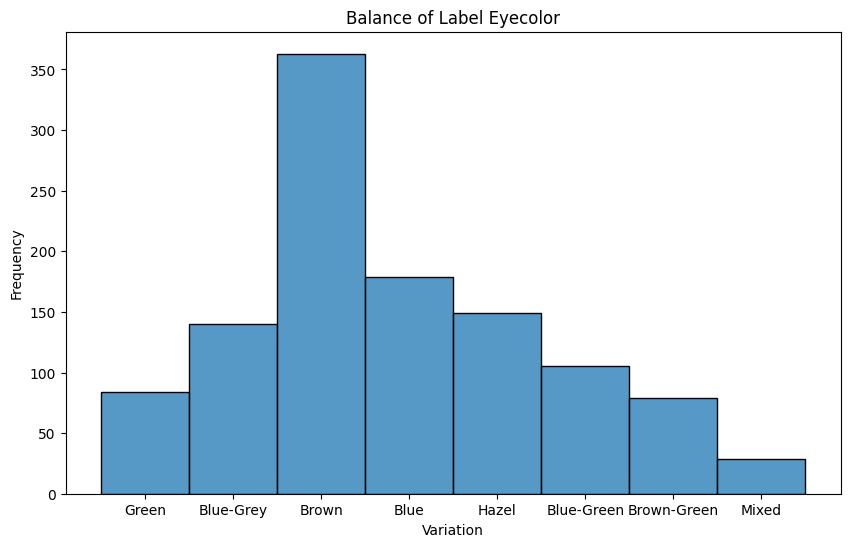

In [7]:
plot_phenotype_distribution(df_encoded, 'eye_color')

The histogram indicates class imbalance with 'Brown' being the most common eye color and 'Mixed' and 'Green' being the least common. For your classification model, this suggests a potential bias towards predicting more common eye colors accurately while less common ones may be underrepresented and thus less accurately predicted. Addressing class imbalance in your model training will be important for robust performance across all eye color categories.

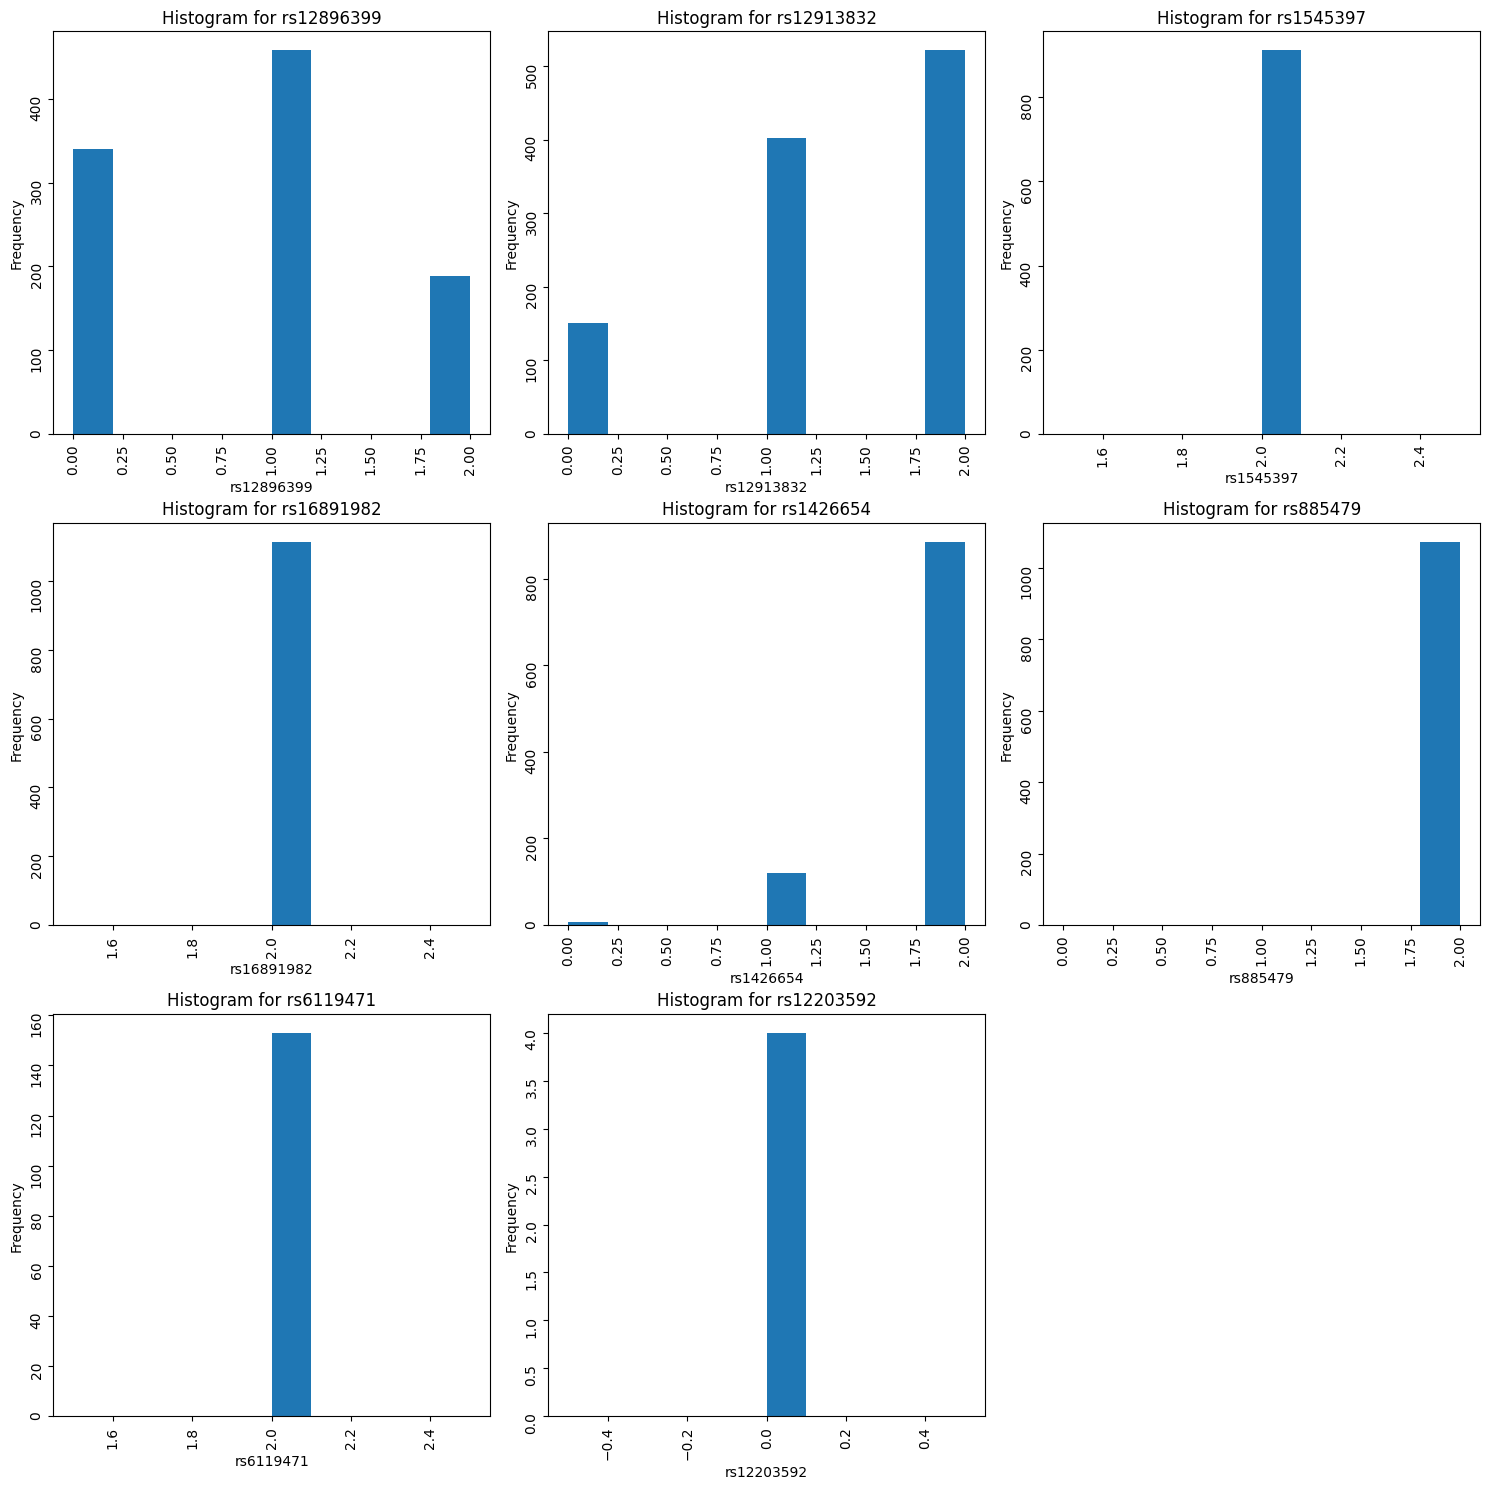

In [8]:
plot_rsin(df_encoded)


The histograms for each SNP show varying levels of genotype frequencies. Some SNPs exhibit a highly skewed distribution towards a single genotype, which might be less informative for classification unless there's a strong link to a phenotype. SNPs with more evenly distributed genotypes could be more useful for the model to differentiate between phenotypes. 

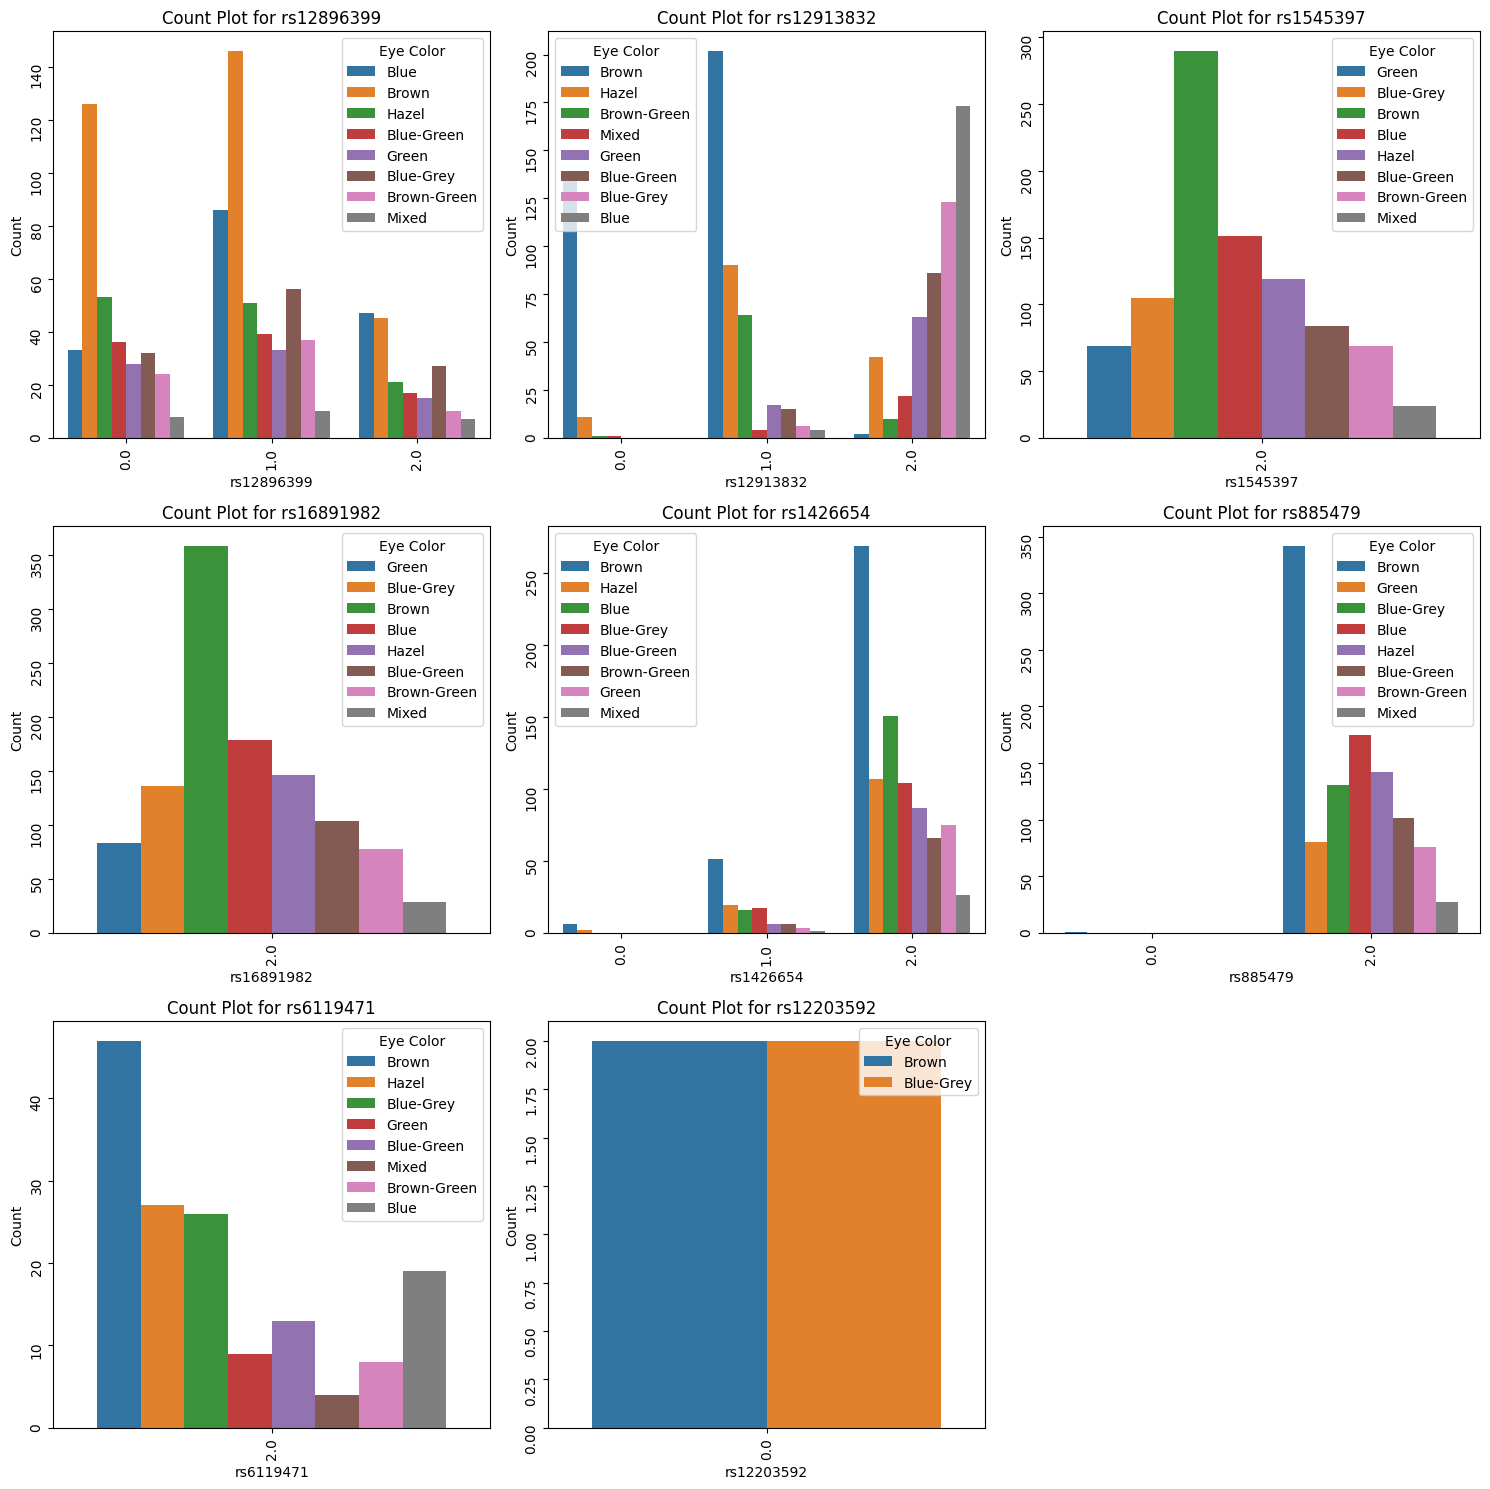

In [9]:
plot_rsin_eyecolor(df_encoded)


The plots show the genotype distribution across different eye colors for specific SNPs. For classification, SNPs with a diverse distribution of genotypes across eye colors (indicating a potential association between the SNP and eye color variation) should be retained. Columns 'rs12203592' and 'rs6119471', which show little to no variation in genotype across different eye colors and a high number of NaNs, might be less informative and should be dropped to simplify the model and potentially improve performance.

In [10]:
df = pd.read_csv(DATA["PREPROCESSED"])

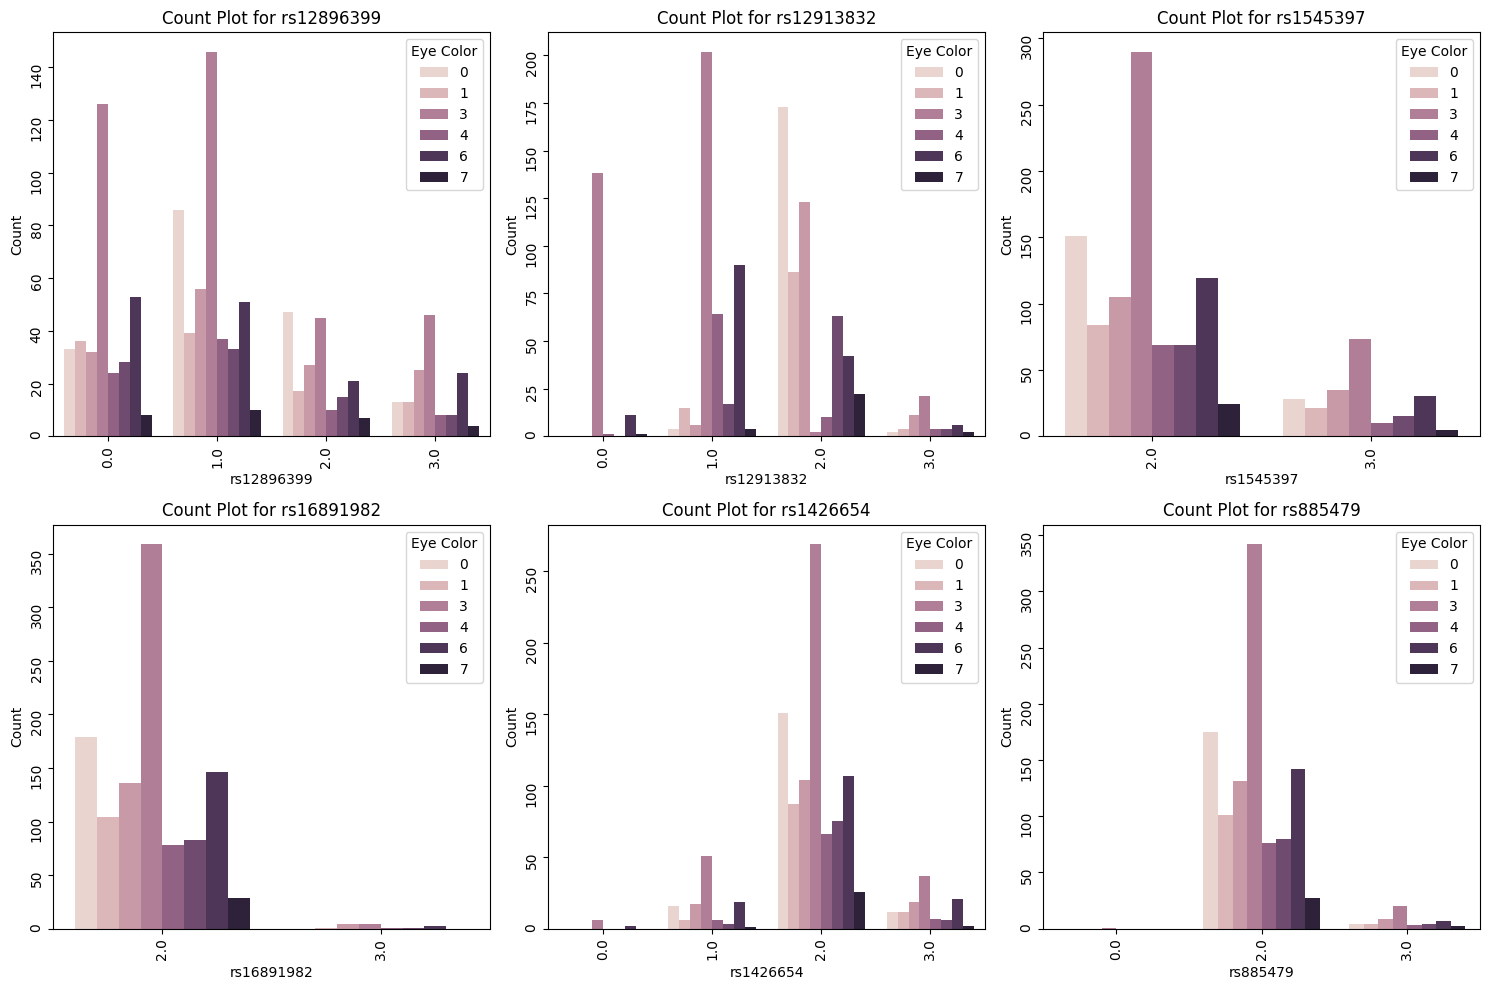

In [11]:
plot_rsin_eyecolor(df)

In [12]:
df.isna().sum()

rs12896399    0
rs12913832    0
rs1545397     0
rs16891982    0
rs1426654     0
rs885479      0
eye_color     0
dtype: int64

No NaN values remaining

# Model evaluation

In [12]:
metrics_df = pd.read_json(EVALUATION['METRICS'])
metrics_df.head()

,LINEAR_ENCODED,XGBOOST,XGBOOST_FINE,LINEAR_NO_NAN
train_loss,1.448928,1.313878,1.400949,1.367870
test_loss,1.514207,1.459450,1.433465,1.449559
test_acc,0.451327,0.442478,0.438053,0.432584
test_aucroc,0.774042,0.775069,0.767348,0.745304


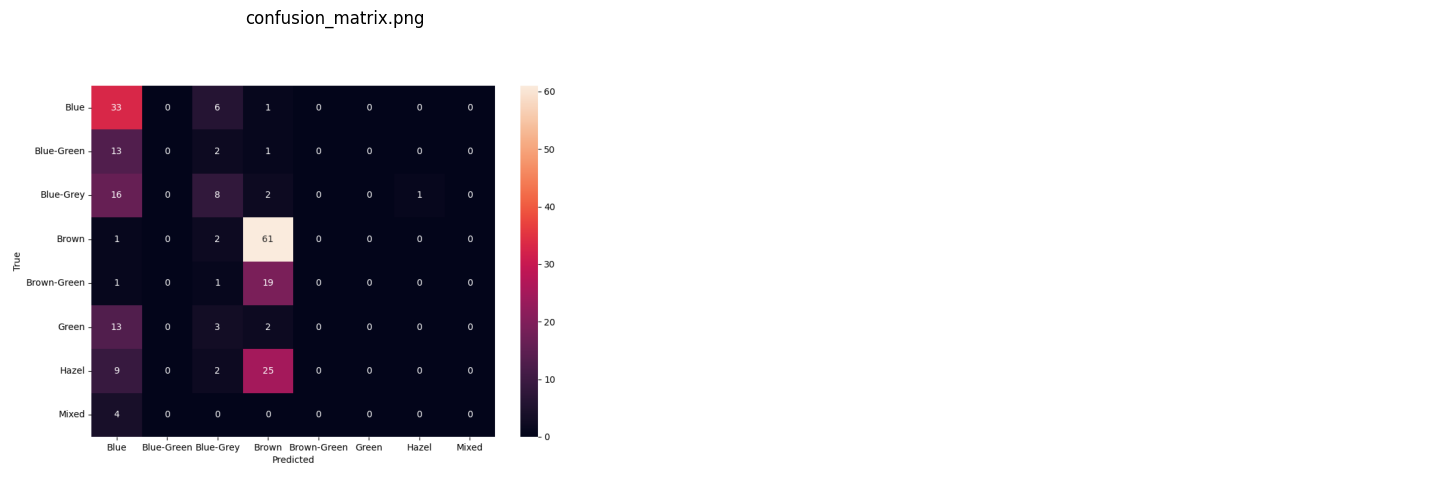

In [13]:
plot_images(EVALUATION["LINEAR"])

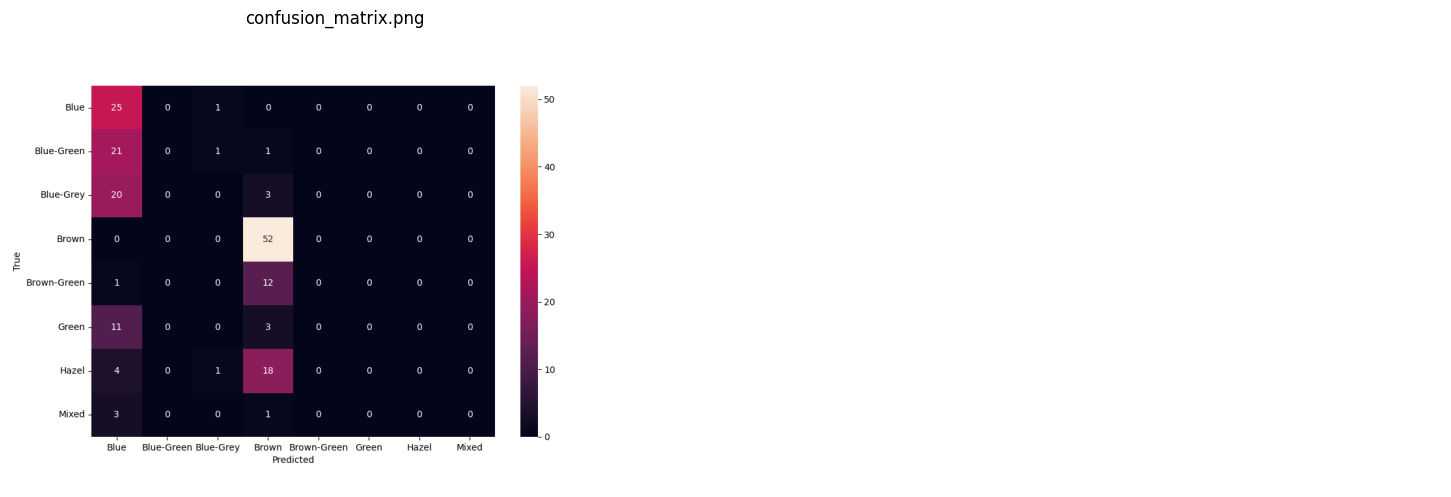

In [7]:
plot_images(EVALUATION["LINEAR_NO_NAN"])

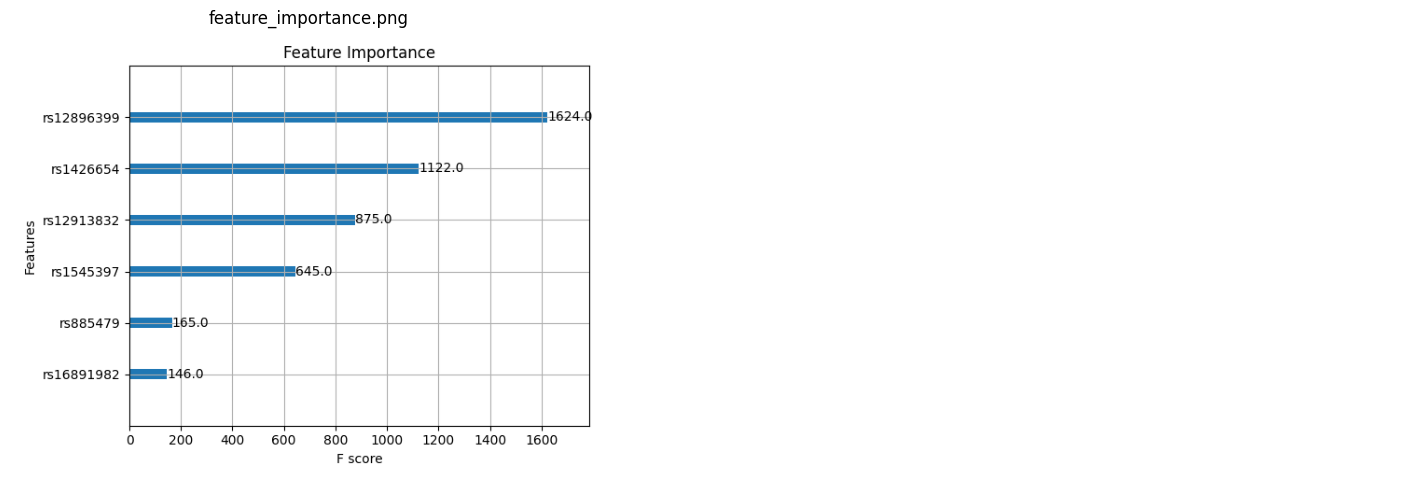

In [21]:
plot_images(EVALUATION["XGBOOST"])